In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)


In [37]:
# Read the sensor data
file_path = 'data/sensor_2_combined_data.xlsx'
df = pd.read_excel(file_path)

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())


Dataset shape: (11561, 6)

Column names:
['datetime', 'upper_humidity', 'upper_temp_F', 'upper_irradiance_W_per_m2', 'sensor_id', 'power_W']

First few rows:
             datetime  upper_humidity  upper_temp_F  \
0 2025-08-12 17:10:00           50.36         91.55   
1 2025-08-12 17:20:00           52.87         90.16   
2 2025-08-12 17:30:00           56.18         88.12   
3 2025-08-12 17:40:00           61.04         85.97   
4 2025-08-12 17:50:00           64.92         85.14   

   upper_irradiance_W_per_m2  sensor_id  power_W  
0                     161.49          2  6375.31  
1                     149.72          2  5845.41  
2                     118.46          2   828.06  
3                     108.07          2   837.23  
4                     128.66          2  4088.62  

Data types:
datetime                     datetime64[ns]
upper_humidity                      float64
upper_temp_F                        float64
upper_irradiance_W_per_m2           float64
sensor_id       

In [38]:
# Identify column names (handle different possible naming conventions)
# Look for power column
power_col = None
for col in df.columns:
    if 'power' in col.lower():
        power_col = col
        break

# Look for irradiance column
irradiance_col = None
for col in df.columns:
    if 'irradiance' in col.lower():
        irradiance_col = col
        break

# Look for temperature column
temp_col = None
for col in df.columns:
    if 'temp' in col.lower() or 'temperature' in col.lower():
        temp_col = col
        break

# Look for humidity column
humidity_col = None
for col in df.columns:
    if 'humidity' in col.lower():
        humidity_col = col
        break

print(f"Power column: {power_col}")
print(f"Irradiance column: {irradiance_col}")
print(f"Temperature column: {temp_col}")
print(f"Humidity column: {humidity_col}")

# Check if all required columns are found
required_cols = [power_col, irradiance_col, temp_col, humidity_col]
if None in required_cols:
    print("\n⚠️ Warning: Some columns not found. Available columns:")
    print(df.columns.tolist())


Power column: power_W
Irradiance column: upper_irradiance_W_per_m2
Temperature column: upper_temp_F
Humidity column: upper_humidity


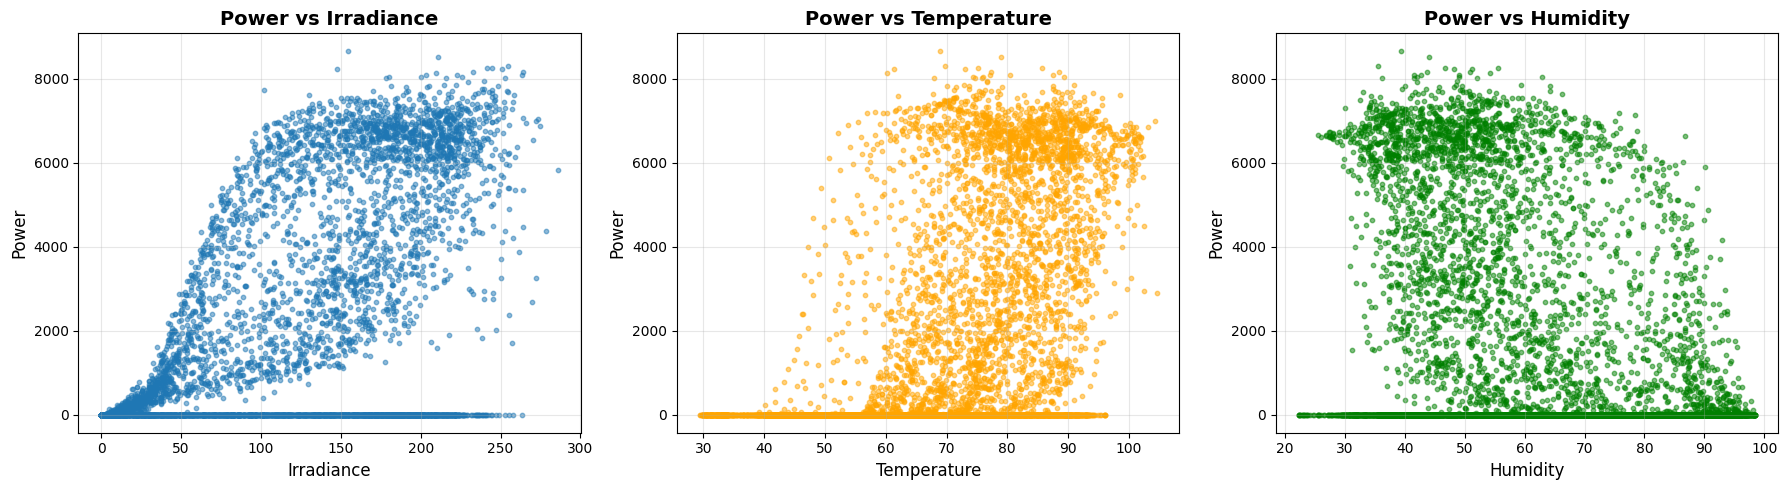


Plotted 11561 data points (after removing missing values)


In [39]:
# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Remove rows with missing values for cleaner plots
plot_df = df[[power_col, irradiance_col, temp_col, humidity_col]].dropna()

# Power vs Irradiance
axes[0].scatter(plot_df[irradiance_col], plot_df[power_col], alpha=0.5, s=10)
axes[0].set_xlabel('Irradiance', fontsize=12)
axes[0].set_ylabel('Power', fontsize=12)
axes[0].set_title('Power vs Irradiance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Power vs Temperature
axes[1].scatter(plot_df[temp_col], plot_df[power_col], alpha=0.5, s=10, color='orange')
axes[1].set_xlabel('Temperature', fontsize=12)
axes[1].set_ylabel('Power', fontsize=12)
axes[1].set_title('Power vs Temperature', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Power vs Humidity
axes[2].scatter(plot_df[humidity_col], plot_df[power_col], alpha=0.5, s=10, color='green')
axes[2].set_xlabel('Humidity', fontsize=12)
axes[2].set_ylabel('Power', fontsize=12)
axes[2].set_title('Power vs Humidity', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPlotted {len(plot_df)} data points (after removing missing values)")


In [46]:
# Step 1: Create lagged power variable
# Sort by time
df_sorted = df.sort_values('datetime').reset_index(drop=True)

# Add power_lag1 (power at previous timestamp, 10 minutes earlier)
df_sorted['power_lag1'] = df_sorted[power_col].shift(1)

# Drop the first row (no lag available)
df_regression = df_sorted.dropna(subset=['power_lag1']).copy()

print(f"Original data points: {len(df_sorted)}")
print(f"Data points after creating lag: {len(df_regression)}")
print(f"\nFirst few rows with lag:")
print(df_regression[['datetime', power_col, 'power_lag1', irradiance_col, temp_col, humidity_col]].head(10))


Original data points: 11561
Data points after creating lag: 11560

First few rows with lag:
              datetime  power_W  power_lag1  upper_irradiance_W_per_m2  \
1  2025-08-12 17:20:00  5845.41     6375.31                     149.72   
2  2025-08-12 17:30:00   828.06     5845.41                     118.46   
3  2025-08-12 17:40:00   837.23      828.06                     108.07   
4  2025-08-12 17:50:00  4088.62      837.23                     128.66   
5  2025-08-12 18:00:00  6106.34     4088.62                     114.02   
6  2025-08-12 18:10:00  5481.71     6106.34                      92.89   
7  2025-08-12 18:20:00  5036.72     5481.71                      79.37   
8  2025-08-12 18:30:00  4481.99     5036.72                      72.37   
9  2025-08-12 18:40:00  3831.58     4481.99                      66.31   
10 2025-08-12 18:50:00  2774.40     3831.58                      61.27   

    upper_temp_F  upper_humidity  
1          90.16           52.87  
2          88.12       

In [49]:
# Step 2: Fit time series regression
# Model: Power_t = β0 + β1·Irrad_t + β2·Temp_t + β3·Humid_t + β4·Power_(t−1) + ε_t

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

# Prepare data for regression
# Remove rows with any missing values in the regression variables
regression_vars = [power_col, irradiance_col, temp_col, humidity_col, 'power_lag1']
df_clean = df_regression[regression_vars].dropna()

print(f"Data points for regression: {len(df_clean)}")

# Define dependent variable (Power_t)
y = df_clean[power_col]

# Define independent variables: Irrad_t, Temp_t, Humid_t, Power_(t-1)
X = df_clean[[irradiance_col, temp_col, humidity_col, 'power_lag1']]

# Add constant term (β0)
X = sm.add_constant(X)

print("\nRegression variables:")
print(f"Dependent variable: {power_col}")
print(f"Independent variables: {irradiance_col}, {temp_col}, {humidity_col}, power_lag1")
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")


Data points for regression: 11560

Regression variables:
Dependent variable: power_W
Independent variables: upper_irradiance_W_per_m2, upper_temp_F, upper_humidity, power_lag1

X shape: (11560, 5)
y shape: (11560,)


In [50]:
# Fit OLS model
model_ols = sm.OLS(y, X).fit()

# Fit OLS with HAC (Newey-West) standard errors
# Using automatic lag selection (default)
model_hac = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': None})

print("="*80)
print("OLS REGRESSION RESULTS (with HAC/Newey-West Standard Errors)")
print("="*80)
print(model_hac.summary())


OLS REGRESSION RESULTS (with HAC/Newey-West Standard Errors)
                            OLS Regression Results                            
Dep. Variable:                power_W   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 1.717e+04
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:19:33   Log-Likelihood:                -91340.
No. Observations:               11560   AIC:                         1.827e+05
Df Residuals:                   11555   BIC:                         1.827e+05
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [43]:
# Step 3: Check diagnostics

print("="*80)
print("REGRESSION DIAGNOSTICS")
print("="*80)

# R²
r_squared = model_hac.rsquared
print(f"\n1. R² (R-squared): {r_squared:.4f}")
print(f"   Interpretation: {r_squared*100:.2f}% of variance in Power is explained by the model")

# Durbin-Watson test on residuals
residuals = model_hac.resid
dw_stat = durbin_watson(residuals)
print(f"\n2. Durbin-Watson statistic: {dw_stat:.4f}")
print(f"   Interpretation:")
print(f"   - DW ≈ 2: No autocorrelation")
print(f"   - DW < 2: Positive autocorrelation (typical range: 0-2)")
print(f"   - DW > 2: Negative autocorrelation (typical range: 2-4)")
if 1.5 < dw_stat < 2.5:
    print(f"   ✓ DW statistic suggests no significant autocorrelation")
else:
    print(f"   ⚠ DW statistic suggests potential autocorrelation")

# Sign and magnitude of coefficients
print(f"\n3. Coefficient Analysis (β₁, β₂, β₃):")
print(f"   {'-'*76}")
print(f"   {'Coefficient':<25} {'Estimate':<15} {'Std Error':<15} {'P-value':<10}")
print(f"   {'-'*76}")

coef_names = {
    irradiance_col: 'β₁ (Irradiance)',
    temp_col: 'β₂ (Temperature)',
    humidity_col: 'β₃ (Humidity)',
    'power_lag1': 'β₄ (Power lag-1)'
}

for var in [irradiance_col, temp_col, humidity_col, 'power_lag1']:
    coef_val = model_hac.params[var]
    std_err = model_hac.bse[var]
    p_val = model_hac.pvalues[var]
    coef_name = coef_names.get(var, var)
    
    sign = "positive" if coef_val > 0 else "negative"
    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    
    print(f"   {coef_name:<25} {coef_val:>14.4f} {std_err:>14.4f} {p_val:>9.4f} {significance}")
    print(f"   {'Sign:':<25} {sign}")
    print(f"   {'Magnitude:':<25} {abs(coef_val):.4f}")
    print()

print(f"\n4. Intercept (β₀): {model_hac.params['const']:.4f}")
print(f"   Standard Error: {model_hac.bse['const']:.4f}")
print(f"   P-value: {model_hac.pvalues['const']:.4f}")


REGRESSION DIAGNOSTICS

1. R² (R-squared): 0.9119
   Interpretation: 91.19% of variance in Power is explained by the model

2. Durbin-Watson statistic: 2.4197
   Interpretation:
   - DW ≈ 2: No autocorrelation
   - DW < 2: Positive autocorrelation (typical range: 0-2)
   - DW > 2: Negative autocorrelation (typical range: 2-4)
   ✓ DW statistic suggests no significant autocorrelation

3. Coefficient Analysis (β₁, β₂, β₃):
   ----------------------------------------------------------------------------
   Coefficient               Estimate        Std Error       P-value   
   ----------------------------------------------------------------------------
   β₁ (Irradiance)                   2.8782         0.2804    0.0000 ***
   Sign:                     positive
   Magnitude:                2.8782

   β₂ (Temperature)                  0.5905         0.5685    0.2990 
   Sign:                     positive
   Magnitude:                0.5905

   β₃ (Humidity)                     6.7083       

In [ ]:
# Process all panels: Repeat regression for each sensor file
from pathlib import Path
import re

# Get all xlsx files in the data folder (excluding temp files)
data_dir = Path('data')
xlsx_files = [f for f in data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

# Sort by sensor number
def get_sensor_number(file_path):
    match = re.search(r'sensor_(\d+)', file_path.stem)
    if match:
        return int(match.group(1))
    return 999

xlsx_files = sorted(xlsx_files, key=get_sensor_number)
print(f"Found {len(xlsx_files)} sensor files to process\n")

# Function to process a single panel
def process_panel(file_path):
    """
    Process a single panel file and return regression results.
    Returns a dictionary with all required statistics.
    """
    try:
        # Read the file
        df = pd.read_excel(file_path)
        
        # Extract panel_id from filename
        match = re.search(r'sensor_(\d+)', file_path.stem)
        panel_id = int(match.group(1)) if match else None
        
        # Check for crop_type column (if it exists)
        crop_type = df.get('crop_type', [None]).iloc[0] if 'crop_type' in df.columns else None
        
        # Identify column names
        power_col = None
        irradiance_col = None
        temp_col = None
        humidity_col = None
        
        for col in df.columns:
            col_lower = col.lower()
            if 'power' in col_lower and power_col is None:
                power_col = col
            if 'irradiance' in col_lower and irradiance_col is None:
                irradiance_col = col
            if ('temp' in col_lower or 'temperature' in col_lower) and temp_col is None:
                temp_col = col
            if 'humidity' in col_lower and humidity_col is None:
                humidity_col = col
        
        # Check if all required columns are found
        if None in [power_col, irradiance_col, temp_col, humidity_col]:
            return {
                'panel_id': panel_id,
                'crop_type': crop_type,
                'status': 'missing_columns',
                'error': f"Missing columns: power={power_col}, irradiance={irradiance_col}, temp={temp_col}, humidity={humidity_col}"
            }
        
        # Sort by time and create lag
        if 'datetime' in df.columns:
            df_sorted = df.sort_values('datetime').reset_index(drop=True)
        else:
            df_sorted = df.copy()
        
        df_sorted['power_lag1'] = df_sorted[power_col].shift(1)
        df_regression = df_sorted.dropna(subset=['power_lag1']).copy()
        
        # Prepare regression data
        regression_vars = [power_col, irradiance_col, temp_col, humidity_col, 'power_lag1']
        df_clean = df_regression[regression_vars].dropna()
        
        if len(df_clean) < 10:  # Need minimum observations
            return {
                'panel_id': panel_id,
                'crop_type': crop_type,
                'status': 'insufficient_data',
                'error': f"Only {len(df_clean)} observations after cleaning"
            }
        
        # Define variables
        y = df_clean[power_col]
        X = df_clean[[irradiance_col, temp_col, humidity_col, 'power_lag1']]
        X = sm.add_constant(X)
        
        # Fit model with HAC standard errors
        model_hac = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': None})
        
        # Calculate Durbin-Watson statistic
        residuals = model_hac.resid
        dw_stat = durbin_watson(residuals)
        
        # Extract coefficients and standard errors
        results = {
            'panel_id': panel_id,
            'crop_type': crop_type,
            'status': 'success',
            'beta_irradiance': model_hac.params[irradiance_col],
            'beta_irradiance_se': model_hac.bse[irradiance_col],
            'beta_temperature': model_hac.params[temp_col],
            'beta_temperature_se': model_hac.bse[temp_col],
            'beta_humidity': model_hac.params[humidity_col],
            'beta_humidity_se': model_hac.bse[humidity_col],
            'beta_lag1': model_hac.params['power_lag1'],
            'beta_lag1_se': model_hac.bse['power_lag1'],
            'r_squared': model_hac.rsquared,
            'durbin_watson': dw_stat,
            'n': len(df_clean)
        }
        
        return results
        
    except Exception as e:
        panel_id_local = None
        crop_type_local = None
        try:
            match = re.search(r'sensor_(\d+)', file_path.stem)
            panel_id_local = int(match.group(1)) if match else None
        except:
            pass
        return {
            'panel_id': panel_id_local,
            'crop_type': crop_type_local,
            'status': 'error',
            'error': str(e)
        }

# Process all panels
all_results = []
for file_path in xlsx_files:
    print(f"Processing {file_path.name}...", end=' ')
    result = process_panel(file_path)
    all_results.append(result)
    if result['status'] == 'success':
        print(f"✓ Success (n={result['n']})")
    else:
        print(f"✗ {result['status']}: {result.get('error', 'Unknown error')}")

print(f"\n{'='*80}")
print(f"Processed {len(all_results)} panels")
print(f"Successful: {sum(1 for r in all_results if r['status'] == 'success')}")
print(f"Failed: {sum(1 for r in all_results if r['status'] != 'success')}")


Found 17 sensor files to process

Processing sensor_1_combined_data.xlsx... ✓ Success (n=11560)
Processing sensor_2_combined_data.xlsx... ✓ Success (n=11560)
Processing sensor_3_combined_data.xlsx... ✓ Success (n=10651)
Processing sensor_4_combined_data.xlsx... ✓ Success (n=9299)
Processing sensor_5_combined_data.xlsx... ✓ Success (n=11290)
Processing sensor_6_combined_data.xlsx... ✓ Success (n=11290)
Processing sensor_9_combined_data.xlsx... ✓ Success (n=716)
Processing sensor_11_combined_data.xlsx... ✓ Success (n=11560)
Processing sensor_12_combined_data.xlsx... ✓ Success (n=10552)
Processing sensor_14_combined_data.xlsx... ✓ Success (n=10097)
Processing sensor_15_combined_data.xlsx... ✓ Success (n=9732)
Processing sensor_17_combined_data.xlsx... ✓ Success (n=11560)
Processing sensor_19_combined_data.xlsx... ✓ Success (n=10572)
Processing sensor_20_combined_data.xlsx... ✓ Success (n=10552)
Processing sensor_22_combined_data.xlsx... ✓ Success (n=7810)
Processing sensor_23_combined_dat

In [33]:
# Combine all results into a DataFrame
results_df = pd.DataFrame(all_results)

# Filter to successful results only
successful_results = results_df[results_df['status'] == 'success'].copy()

# Select and reorder columns for the final table
final_columns = [
    'panel_id',
    'crop_type',
    'beta_irradiance',
    'beta_irradiance_se',
    'beta_temperature',
    'beta_temperature_se',
    'beta_humidity',
    'beta_humidity_se',
    'beta_lag1',
    'beta_lag1_se',
    'r_squared',
    'durbin_watson',
    'n'
]

results_table = successful_results[final_columns].copy()

# Sort by panel_id
results_table = results_table.sort_values('panel_id').reset_index(drop=True)

print("="*80)
print("COMBINED RESULTS TABLE")
print("="*80)
print(f"\nTotal panels with successful regressions: {len(results_table)}")
print(f"\nResults summary:")
print(results_table.describe())

print(f"\n{'='*80}")
print("Full Results Table:")
print("="*80)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(results_table)


COMBINED RESULTS TABLE

Total panels with successful regressions: 17

Results summary:
        panel_id  beta_irradiance  beta_irradiance_se  beta_temperature  \
count  17.000000        17.000000           17.000000         17.000000   
mean   12.176471         6.236862            0.624339         -1.846044   
std     7.812132         3.710969            0.435980          4.061585   
min     1.000000         0.687209            0.124719        -10.240427   
25%     5.000000         2.878160            0.280393         -3.008958   
50%    12.000000         7.712853            0.587260         -2.380606   
75%    19.000000         8.880190            0.711557          0.487691   
max    24.000000        11.135763            1.833218          8.039747   

       beta_temperature_se  beta_humidity  beta_humidity_se  beta_lag1  \
count            17.000000      17.000000         17.000000  17.000000   
mean              1.435142       5.168832          1.138921   0.831874   
std            

In [36]:
# Save results to CSV file in data/ directory
output_file_csv = 'data/panel_regression_results.csv'
results_table.to_csv(output_file_csv, index=False)
print(f"\n{'='*80}")
print(f"Results saved to: {output_file_csv}")
print("="*80)

# Display summary statistics
print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nCoefficient Statistics:")
print(f"  β_irradiance:   mean={results_table['beta_irradiance'].mean():.4f},   std={results_table['beta_irradiance'].std():.4f}")
print(f"  β_temperature:  mean={results_table['beta_temperature'].mean():.4f},  std={results_table['beta_temperature'].std():.4f}")
print(f"  β_humidity:     mean={results_table['beta_humidity'].mean():.4f},     std={results_table['beta_humidity'].std():.4f}")
print(f"  β_lag1:         mean={results_table['beta_lag1'].mean():.4f},         std={results_table['beta_lag1'].std():.4f}")
print(f"\nModel Fit:")
print(f"  R²:             mean={results_table['r_squared'].mean():.4f},         std={results_table['r_squared'].std():.4f}")
print(f"  Durbin-Watson: mean={results_table['durbin_watson'].mean():.4f},      std={results_table['durbin_watson'].std():.4f}")
print(f"  Sample size:    mean={results_table['n'].mean():.0f},                std={results_table['n'].std():.0f}")



Results saved to: data/panel_regression_results.csv

SUMMARY STATISTICS

Coefficient Statistics:
  β_irradiance:   mean=6.2369,   std=3.7110
  β_temperature:  mean=-1.8460,  std=4.0616
  β_humidity:     mean=5.1688,     std=2.9346
  β_lag1:         mean=0.8319,         std=0.0937

Model Fit:
  R²:             mean=0.9164,         std=0.0093
  Durbin-Watson: mean=2.3306,      std=0.1538
  Sample size:    mean=9676,                std=2665


In [35]:
# Display any failed panels for debugging
failed_panels = results_df[results_df['status'] != 'success']
if len(failed_panels) > 0:
    print(f"\n{'='*80}")
    print("FAILED PANELS (for debugging)")
    print("="*80)
    print(failed_panels[['panel_id', 'status', 'error']])
else:
    print("\n✓ All panels processed successfully!")



✓ All panels processed successfully!
